In [1]:
import sys
sys.path.append('/home/alex/Translation-Team08-IFT6759/code')

In [2]:
import tokenizer

In [3]:
en_file1 = '../data/train.lang1.no-punctuation/train.lang1'
en_file2 = '../data/train.en.no-punctuation/unaligned.en'
fr_file1 = '../data/train.lang2.no-punctuation/train.lang2'
fr_file2 = '../data/train.fr.no-punctuation/unaligned.fr'
files = [[en_file1, en_file2], [fr_file1, fr_file2]]
corpus_name = ['EN', 'FR']

In [4]:
from collections import Counter

def get_stats(lang_files):
    line_lengths = []
    my_counter = Counter()
    for lang_file in lang_files:
        with open(lang_file) as f:
            for line in f:
                tokens = line.split()
                line_lengths += [len(tokens)]
                for token in tokens:
                    my_counter.update([token])
    return my_counter, line_lengths

corpus_line_lengths = []
counters = []
for lang_files in files:
    my_counter, line_lengths = get_stats(lang_files)
    counters += [my_counter]
    corpus_line_lengths += [line_lengths]

In [5]:
for my_counter, corpus in zip(counters, corpus_name):
    print(f'number of unique tokens in {corpus} corpus: {len(my_counter)}')

number of unique tokens in EN corpus: 60453
number of unique tokens in FR corpus: 83983


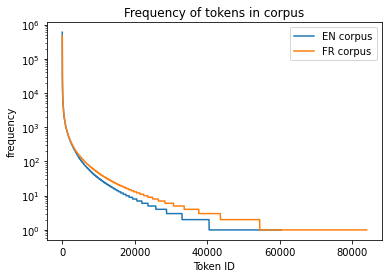

In [6]:
import matplotlib.pyplot as plt

for my_counter, corpus in zip(counters, corpus_name):
    plt.plot(range(len(my_counter.values())), sorted(my_counter.values(), reverse=True), label=f'{corpus} corpus')
    plt.yscale('log')
    plt.xlabel('Token ID')
    plt.ylabel('frequency')
    plt.title(f'Frequency of tokens in corpus')
plt.legend()
plt.show()

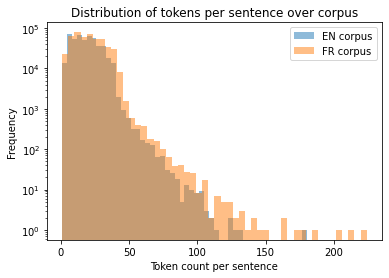

In [7]:
for line_lengths, corpus in zip(corpus_line_lengths, corpus_name):
    plt.hist(line_lengths, bins=50, alpha=0.5, label=f'{corpus} corpus')
    plt.xlabel('Token count per sentence')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title(f'Distribution of tokens per sentence over corpus')
plt.legend()
plt.show()

In [8]:
for line_lengths, corpus in zip(corpus_line_lengths, corpus_name):
    print(f'max number of tokens per {corpus} sentence: {max(line_lengths)}')

max number of tokens per EN sentence: 180
max number of tokens per FR sentence: 224


In [9]:
for my_counter, corpus in zip(counters, corpus_name):
    print(f'Most common tokens in {corpus} corpus: {my_counter.most_common(5)}')

Most common tokens in EN corpus: [('the', 599628), ('to', 285851), ('of', 281659), ('and', 231575), ('in', 195314)]
Most common tokens in FR corpus: [('de', 472698), ('la', 305382), ('et', 215933), ('le', 214443), ('les', 201676)]
